# Chapter5. 通过降维压缩数据
无监督数据压缩——主成分分析（Principal Component Analysis，PCA）

基于类别最大化的监督降维——线性判别分析（Linear Discriminant Analysis，LDA）

非线性降维——核主成分分析（Kernel Principal Component Analysis，KPCA）

In [1]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## 1. 无监督数据降维——PCA
PCA的目标实在高维数据中找到最大方差方向，并将数据映射到一个维度不大于原始维度的新的子空间上。
1. 对原始$d$维的数据集做标准化处理；
2. 构造样本的协方差矩阵；
3. 计算协方差矩阵的特征值和特征向量；
4. 选择前$k$个最大特征值和对应的特征向量，其中$k$为新的子空间维度$(k\leq{d})$；
5. 通过前$k$个特征向量构造映射矩阵$W$；
6. 通过映射矩阵$W$将$d$维的输入数据集$X$转换到新的$k$维特征子空间。

### a. 总体方差与贡献方差

加载葡萄酒数据集，并标准化

In [2]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
# 这里不能使用fit_transform来标准化测试集，为了保证测试集和训练集有相同的缩放，
# 需要使用训练集的均值和方差来标准化测试集。原因如下
X_test_std = sc.transform(X_test)

---

**Note**

当使用 `X_test_std = sc.fit_transform(X_test)` 代替 `X_test_std = sc.transform(X_test)`时， 它们应该不会有太大差异，因为测试集的均值和误差应该和整个训练集的很接近。但是，在第三章中，我们提到，当我们进行标准化的时候，正确的方法应该是使用训练集的均值和方差来对测试集进行操作，测试集应该是一种“不可见”的新数据集，我们不应该知道它的均值和方差。

这里有个小例子来解释这个问题：

假设我们有一个包含了3个样本，1个特征（名为长度）的数据集:

- train_1: 10 cm -> class_2
- train_2: 20 cm -> class_2
- train_3: 30 cm -> class_1

mean: 20, std.: 8.2

标准化后，数据集变成了如下所示：

- train_std_1: -1.21 -> class_2
- train_std_2: 0 -> class_2
- train_std_3: 1.21 -> class_1

然后，我们假设训练好的模型可以对样本进行分类，当标准化后的特征值<0.6时划分到class_2，否则为class_1。现在我们有三个待分类的样本：

- new_4: 5 cm -> class ?
- new_5: 6 cm -> class ?
- new_6: 7 cm -> class ?

如果我们观察未标准化的训练样本，上面这三个测试样本直观上应该属于class_2，但是如果我们在测试样本上重新计算均值和方差，并将测试集标准化后会得到和训练集标准化后类似的结果，这样就会将第6个样本划分到了class_1。

- new_std_4: -1.21 -> class 2
- new_std_5: 0 -> class 2
- new_std_6: 1.21 -> class 1

但是，如果我们使用训练集的均值和方差来标准化测试集，那么就会有如下结果：

- sample4: -18.37 -> class 2
- sample5: -17.15 -> class 2
- sample6: -15.92 -> class 2

5cm，6cm，7cm这三个值比之前训练集样本的值要小很多，新样本使用训练集的均值和方差标准化后的数据比标准化的训练集也应该小很多，从上面输出看，确实如此，这样才能对测试集进行正确的分类。

---

代码预处理完成后就可以计算协方差了：
$$\sigma_{jk}=\frac1n\sum_{i=1}^{n}(x_j^{(i)} - \mu_j)(x_k^{(i)} - \mu_k)$$
其中，$x_j^{(i)}$和$x_k^{(i)}$分别是两个特征，$\mu_j$和$\mu_k$分别是特征$j$和$k$的均值，由于做了标准化，他们的均值均为0，一个包含3个特征的协方差矩阵如下所示：
$$\Sigma = \begin{bmatrix} \sigma_1^2 & \sigma_{12} & \sigma_{13} \\
                           \sigma_{21} & \sigma_2^2 & \sigma_{23} \\
                           \sigma_{31} & \sigma_{32} & \sigma_3^2 \\
           \end{bmatrix}$$
计算出协方差矩阵后对其求特征值，然后将特征值排序。

In [4]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print("\nEigenvalues \n%s" % eigen_vals)


Eigenvalues 
[4.8923083  2.46635032 1.42809973 1.01233462 0.84906459 0.60181514
 0.52251546 0.08414846 0.33051429 0.29595018 0.16831254 0.21432212
 0.2399553 ]


通过特征分解，我们得到了13个特征值和一个由13个特征向量构成的矩阵，矩阵的每列对应着一个特征向量。

上面使用的是`numpy.linalg.eig`，可以用它，但并不是最理想的。当输入矩阵不是对称阵的时候，可能会输出复数特征值，所以它并不是一个数值稳定的方法。可以使用`numpy.linalg.eigh`来代替，它总会返回一个实特征值。

下面我们绘制特征值的方差贡献率曲线，方差贡献率如下：
$$k = \frac{\lambda_j}{\sum_{i=1}^{d}\lambda_i}$$

In [5]:
tot = sum(eigen_vals)
# 将特征值从大到小排序后，计算每个特征值的方差贡献率
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# cumsum返回分段累加和，a[0] = s[0], a[1] = s[0] + s[1]...
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.37329648, 0.56148574, 0.67045365, 0.74769754, 0.81248349,
       0.85840362, 0.89827298, 0.92349212, 0.94607393, 0.96438317,
       0.98073654, 0.99357924, 1.        ])

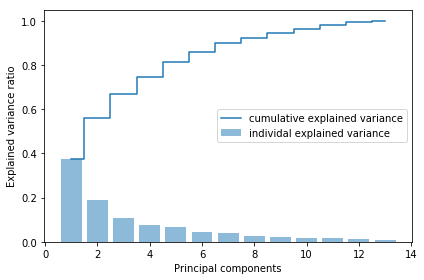

In [7]:
import matplotlib.pyplot as plt

# 绘制直方图，range表示绘制的范围，alpha表示颜色深度，align表示对齐方式
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individal explained variance')
# 绘制分段函数
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### b. 特征转换
对特征值进行降序排列，挑选出对应的特征向量构造映射矩阵，然后把原始特征空间转换到低维子空间。

In [8]:
# 将特征值降序排列，构造特征值，特征向量组合
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# 按照特征值大小对上面的列表排序
eigen_pairs.sort(key = lambda k: k[0], reverse=True)

选择两个特征向量进行显示。

In [9]:
# hstack将两个np数组按列方式组合，相当于并排放在一起，vstack相当于摞在一起
# np.newaxis在列方向增加一个维度
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


In [10]:
# 将样本进行转换
X_train_std[0].dot(w)

array([2.59891628, 0.00484089])

新的样本是一个包含两个特征的向量

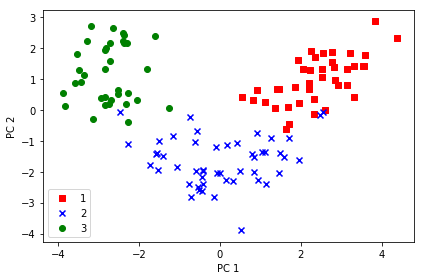

In [11]:
# 转换整个数据集
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m, in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
                X_train_pca[y_train == l, 1], 
                color=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### c. 使用sklearn进行主成分分析

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
# 方差贡献率
pca.explained_variance_ratio_

array([0.37329648, 0.18818926, 0.10896791, 0.07724389, 0.06478595,
       0.04592014, 0.03986936, 0.02521914, 0.02258181, 0.01830924,
       0.01635336, 0.01284271, 0.00642076])

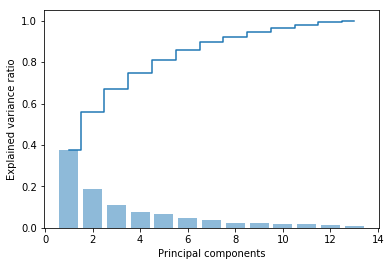

In [13]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

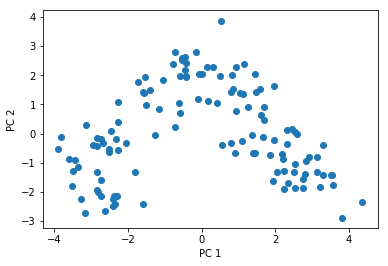

In [14]:
# n_components主成分数量
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [15]:
from matplotlib.colors import ListedColormap

# 绘制决策边界
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

使用逻辑回归分类器学习前两个特征。

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', multi_class='auto')
lr = lr.fit(X_train_pca, y_train)

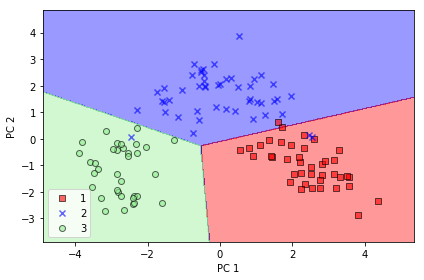

In [17]:
# 训练集决策边界
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

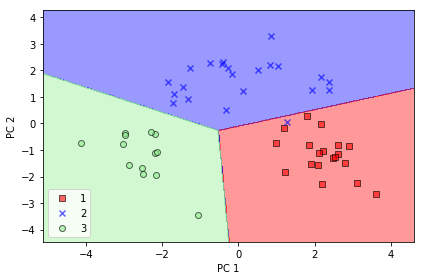

In [18]:
# 测试集决策边界
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

可以看到效果还是很不错的。

如果我们对不同主成分的方差贡献率感兴趣，可以将PCA类中的n_components参数设为None，可以保留所有的主成分，然后可以通过explained_variance_ratio_来获得贡献率：

In [19]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.37329648, 0.18818926, 0.10896791, 0.07724389, 0.06478595,
       0.04592014, 0.03986936, 0.02521914, 0.02258181, 0.01830924,
       0.01635336, 0.01284271, 0.00642076])

## 2. 通过线性判别分析压缩有监督数据
PCA试图在数据集中找到方差最大的正交主成分分量的轴，也就是特征向量，而LDA的目标则是发现可以最优化分类的特征子空间。

1. 对$d$维数据进行标准化处理（$d$为特征数量）；
2. 对每一类别，计算$d$维的均值向量；
3. 构造类间的散度矩阵$S_B$以及类内散度矩阵$S_W$；
4. 计算矩阵$S_W^{-1}S_B$的特征值及对应的特征向量；
5. 选取前$k$个特征值对应的特征向量，构造一个$d×k$维的转换矩阵$W$，其中特征向量以列的形式排列；
6. 使用转换矩阵$W$将样本映射到新的特征子空间上。

### a. 计算散度矩阵
首先计算均值向量，$\boldsymbol{m_i}$存储了类别$i$中的样本的特征均值：
$$\boldsymbol{m_i}=\frac1{n_i}\sum_{x\in{D_i}}^{c}\boldsymbol{x_m}$$

$c$为类别数量。对应到葡萄酒数据集，三个类别分别对应了三个均值向量：
$$\boldsymbol{m_i}=
\begin{bmatrix} \mu_{i,alcohol} \\
                 \mu_{i,malic acid} \\
                 \vdots \\
                 \mu_{i,proline} \end{bmatrix} 
                 i\in\{1, 2, 3\}$$
                 
通过均值向量可以计算类内散度矩阵$S_W$：
$$S_W=\sum_{i=1}^cS_i$$
$S_i$可以通过累加各类别$i$的散度矩阵$S_i$来计算：
$$S_i = \boldsymbol{(x-m_i)(x-m_i)}^T$$
类内散度矩阵刻画了不同类别之间的距离。类间散度矩阵刻画了同类别样本的方差。

In [20]:
# 计算每个类别的特征均值
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print("MV %s: %s\n" % (label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



上面每个MV代表了一个类别，每个类别里包含了一个13列的均值向量，每个元素是对应特征在标准化训练样本上的均值。然后就可以计算类内散度矩阵了：

In [21]:
d = 13
S_W = np.zeros((d, d))

# range代表三个类别1,2,3
for label, mv in zip(range(1, 4), mean_vecs):
    # class_scatter:当前类别的散度矩阵
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        # row为单个样本的列向量，mv为每个类别的特征均值的列向量
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
    
print("Within-class scatter matrix: %sx%s" % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


之前我们计算散度矩阵时假设训练集的类标是均匀分布的，但是，通过对比类标的数量，发现并不是如此：

In [22]:
# bincount:统计目标向量中从0到len(x)的所有数出现的次数，这里统计的就是1,2,3这三个类标出现的次数。
print("Class label distribution: %s" % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


由于类内散度矩阵并不是均匀分布的，所以要对它们进行缩放。缩放的方式就是计算协方差矩阵（为什么不一开始就用协方差矩阵呢？）：
$$\Sigma_i = \frac1{N_i}{\bf {S_W}} = \frac1{N_i}\sum_{x\in{D_i}}^c\boldsymbol{(x-m_i)(x-m_i)^T}$$

In [23]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    # 计算每个类别的协方差矩阵，并相加得到类内散度矩阵
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

print("Scaled within-class scatter matrix: %sx%s" % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


计算完类内散度矩阵后可以计算类间散度矩阵$S_B$：
$${\bf S_B} = \sum_{i=1}^cN_i\boldsymbol{(m_i - m)(m_i - m)^T}$$
其中$\boldsymbol m$为全局均值，计算它的时候用到了所有类别的样本。

In [24]:
# mean_overall：所有样本每个特征的均值组成的d维向量
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    # 属于第i个类别的样本数量
    n = X_train[y_train == i + 1, :].shape[0]
    # 列转换
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
    
print("Between-class scatter matrix: %sx%s" % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


### b. 在新的特征子空间选取线性判别算法
LDA余下的步骤和PCA相似，但是这里我们不对协方差矩阵做特征分解，而是求解矩阵$S_W^{-1}S_B$的广义特征值

In [25]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

对特征值按降序排序。

In [26]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print("Eigenvalues in decreasing order:\n")
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.72158124497435
156.43636121952323
1.0564670343472254e-13
3.996418537019543e-14
3.409235652909593e-14
2.842170943040401e-14
1.4793035293048285e-14
1.4793035293048285e-14
1.3494134504023504e-14
1.3494134504023504e-14
6.491059855852737e-15
6.491059855852737e-15
2.655812157040677e-15


为了度量线性判别可以获取多少区分类别有用的信息，可以按照特征降序绘制出特征对信息保持程度的图像：

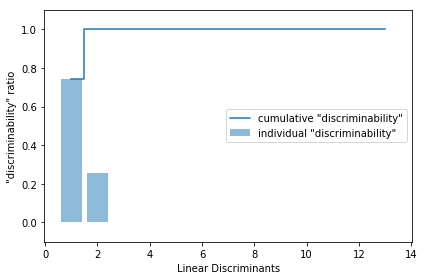

In [27]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

可以看出前两个线性判别几乎获取了葡萄酒训练数据集中全部的有用信息。下面就可以用它们来构造转换矩阵$W$：

In [28]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))
print("Matrix W:\n", w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


使用上述矩阵对特征空间进行转换：
$$X' = XW$$

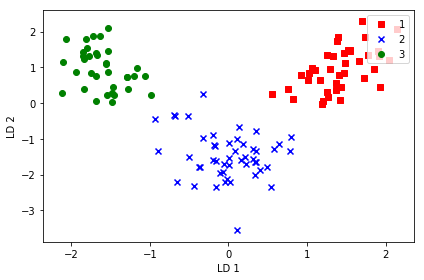

In [30]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    # 乘-1为了翻转图像，为什么这么做？
    plt.scatter(X_train_lda[y_train == l, 0] * (-1),
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### c. 使用sklearn进行LDA分析

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

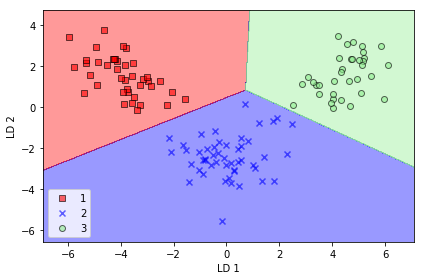

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', multi_class='auto')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

下面看一下在测试集上的效果：

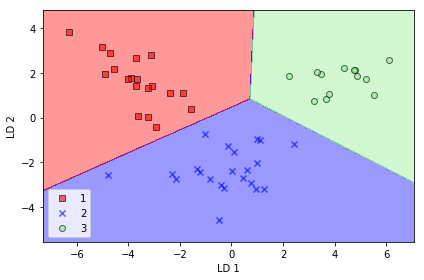

In [33]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 2. 使用核主成分分析进行非线性映射
本节我们了解利用核技巧的PCA将非线性可分的数据转换到一个合适对其进行线性分类的新的低维子空间上。
### a. 核函数与核技巧
基于RBF核的PCA：
1. 为了计算核相似矩阵，需要计算：
    $$\kappa(x^{(i)},x^{(j)})=exp(-\gamma||x^{(i)}-x^{(j)}||^2)$$
2. 通过如下公式聚集核矩阵：
    $${\bf K'}={\bf K} - l_n{\bf K}-{\bf K}l_n + l_n{\bf K}l_n$$
    其中$l_n$是一个$n\times{n}$维的矩阵，其所有均值均为$\frac1n$。
3. 将聚集后的核矩阵的特征值按照降序排列，选择前$k$个特征值所对应的特征向量。和PCA不同的是，这些特征值不是主成分轴，而是将样本映射到这些轴上。

In [34]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from numpy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   

    """
    # 计算两两样本之间的欧氏距离平方，计算出的距离个数是(N, 2)的组合数
    sq_dists = pdist(X, 'sqeuclidean')
    
    # 把上述两两距离矩阵转换成方阵，主对角线元素为零，其他为各个向量之间的欧氏距离平方
    # 而且它是一个对角阵
    mat_sq_dists = squareform(sq_dists)
    
    # 计算对称核矩阵
    K = exp(-gamma * mat_sq_dists)
    
    # 聚集对称核矩阵
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # 求核矩阵的特征值和特征向量
    eigvals, eigvecs = eigh(K)
    
    # 获取特征值排前k的特征向量组成样本矩阵
    # 这里没有使用样本进行转换的过程，求得核矩阵的前k个特征值后就直接当做训练样本使用
    X_pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))
    
    return X_pc

**示例一**<br>
分离半月形数据

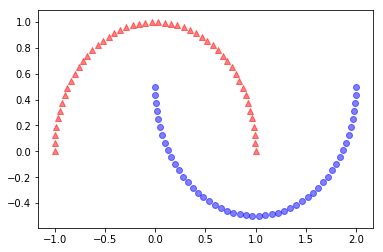

In [35]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

使用核PCA分离两者

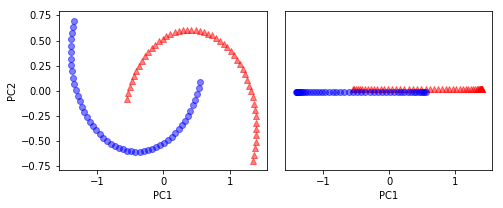

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

# 绘制经过标准PCA转换后的图像
ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

# 只绘制第一主成分的图像，后面+-0.02是为了向上向下微调图像，显示重叠区域
ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

数据经过标准PCA降维后，仍然线性不可分。如右图所示，只绘制第一主成分的图像时为了更好的表现出类间重叠，分别对两个样本向上和向下做了调整。

下面使用核PCA对上述数据进行降维处理：

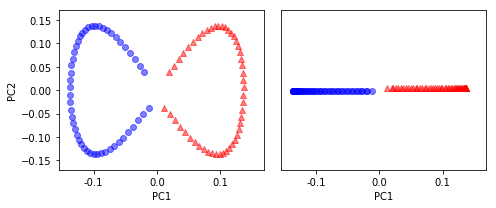

In [37]:
from matplotlib.ticker import FormatStrFormatter

X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

plt.tight_layout()
plt.show()

由上图可以看出，原本线性不可分的高维数据集，被降到二维，而且已经变得线性可分。

**示例二**<br>
分离同心圆

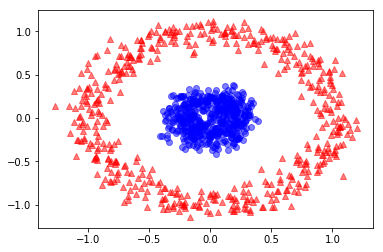

In [38]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

同样，首先使用标准PCA进行处理：

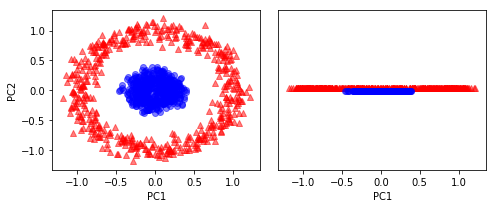

In [39]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('./figures/circles_2.png', dpi=300)
plt.show()

可以看到，是非线性可分的。下面使用核PCA：

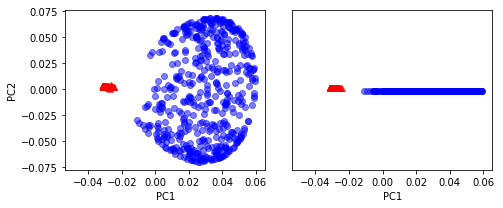

In [40]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

数据变得线性可分。

### b. 映射新的数据点
在上面两个例子中，我们将单一数据集映射到了一个新的特征上，下面我们介绍如何训练数据集外的数据进行映射.
$$\phi(x')^Tv=\sum_ia^{(i)}\phi(x')^T\phi(x^{(i)})=\sum_ia^{(i)}k(x',x^{(i)})^T$$
其中，$x'$是待映射的新样本点，核矩阵$\bf K$的特征向量$\bf a$及其特征值$\lambda$满足:
$${\bf K}{\bf a} = \lambda{\bf a}$$

可以改写上面`rbf_kernel_pca`函数，让其返回核矩阵的特征值，然后计算其他数据集的映射结果。

In [41]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   
     
     lambdas: list
       Eigenvalues

    """
    # 计算两两样本之间的欧氏距离平方，计算出的距离个数是(N, 2)的组合数
    sq_dists = pdist(X, 'sqeuclidean')
    
    # 把上述两两距离矩阵转换成方阵，主对角线元素为零，其他为各个向量之间的欧氏距离平方
    # 而且它是一个对角阵
    mat_sq_dists = squareform(sq_dists)
    
    # 计算对称核矩阵
    K = exp(-gamma * mat_sq_dists)
    
    # 聚集对称核矩阵
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # 求核矩阵的特征值和特征向量
    eigvals, eigvecs = eigh(K)
    
    # 获取前k个特征值对应的特征向量（样本数据）
    alphas = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))
    
    # 获取对应的特征值
    lambdas = [eigvals[-i] for i in range(1, n_components + 1)]
    
    return alphas, lambdas

In [42]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [43]:
# 需要映射的样本点
x_new = X[-1]
x_new

array([ 0.4816, -0.3551])

In [45]:
# 原始投影
x_proj = alphas[-1]
x_proj

array([0.1192])

In [48]:
# 计算新样本点的投影
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# 新数据点的投影
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([0.1192])

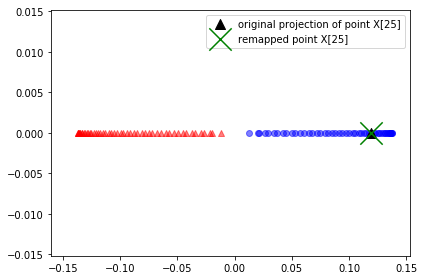

In [47]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
plt.show()

可以看到新样本点映射得到的结果是和原来映射的结果相同的，通过图示也可以看出，新样本点也被正确映射到了一维空间。

### c. scikit-learn中的核主成分分析

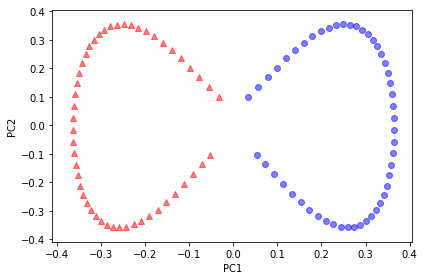

In [51]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()